### Bagging (Bootstrap Aggregation) and Random Forest 
- and a brief discussion of boosting


### Decision Trees 

- To learn a decision tree model, we take a greedy approach:
    - Start with an empty decision tree (undivided feature space)
    - Choose the ‘optimal’ predictor by comparing entropy with and without the predictor (information gain)
    - Choose the ‘optimal’ threshold value for splitting by applying a splitting criterion
    - Recurse on each new node until stopping condition is met 
        - max_depth
        - min_samples_split
        - min_samples_leaf

- For classification, we label each region in the model with the label of the class to which the plurality of the points within the region belong.
- For regression, we predict with the average of the output values of the training points contained in the region .

In [133]:
# imports
import numpy as np
import pandas as pd
from scipy.stats import gamma
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.inspection import permutation_importance
from sklearn.inspection import partial_dependence




### Let's revisit the PIMA Indians diabetes data.

In [134]:
# load in the data
pima = pd.read_csv("../data/diabetes_nan.csv")
pima = pima.dropna()
pima.info()
cols = pima.columns
diabetes = pima['Outcome']
predictors = pima[cols[1:8]]


<class 'pandas.core.frame.DataFrame'>
Index: 392 entries, 3 to 765
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               392 non-null    int64  
 1   Glucose                   392 non-null    float64
 2   BloodPressure             392 non-null    float64
 3   SkinThickness             392 non-null    float64
 4   Insulin                   392 non-null    float64
 5   BMI                       392 non-null    float64
 6   DiabetesPedigreeFunction  392 non-null    float64
 7   Age                       392 non-null    int64  
 8   Outcome                   392 non-null    int64  
dtypes: float64(6), int64(3)
memory usage: 30.6 KB


One way I can specify parameters to prevent overfitting is to specify `max_depth` of the tree 

In [135]:
# isolate out the data we need
X             = np.array(predictors)
y             = np.array(diabetes)
class_names   = class_names=['Undiagnosed','Diabetes']
feature_names = cols[1:8]

# perform a train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# fit a decision tree classifier with max_depth=3
dt_pima = DecisionTreeClassifier(max_depth=3, random_state=42, criterion = 'entropy')
#dt_pima = DecisionTreeClassifier(min_samples_split =5, random_state=42, criterion = 'entropy')

dt_pima.fit(X_train,y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=42)

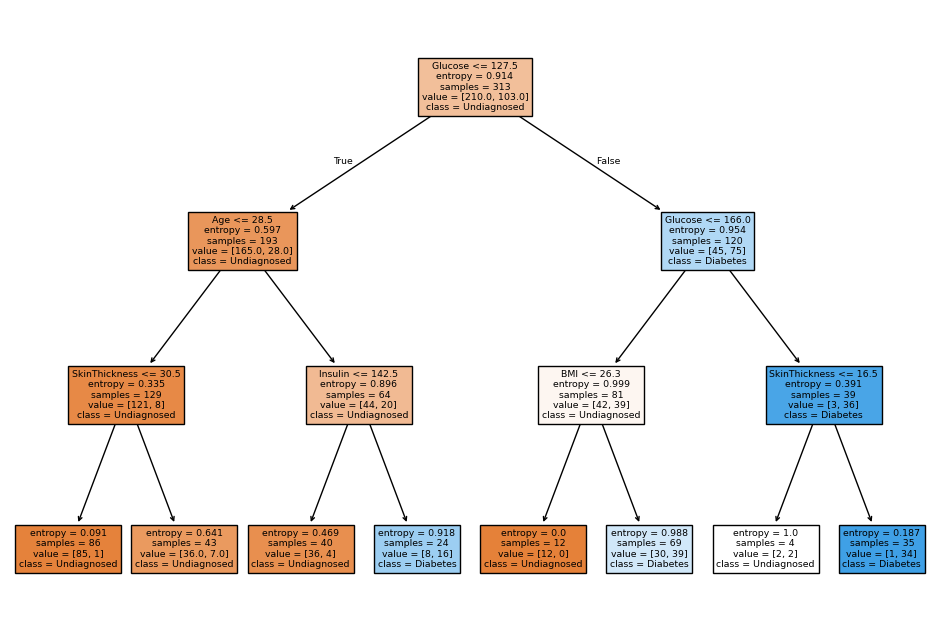

In [136]:
plt.figure(figsize = (12,8))
plot_tree(dt_pima, filled=True, feature_names = feature_names, class_names = class_names)
plt.show()

In [137]:
y_pred = dt_pima.predict(X_test)
print('accuracy score:', dt_pima.score(X_test, y_test))


accuracy score: 0.7341772151898734


In [138]:
cnf_matrix = confusion_matrix(y_test, y_pred)
print(cnf_matrix)

[[39 13]
 [ 8 19]]


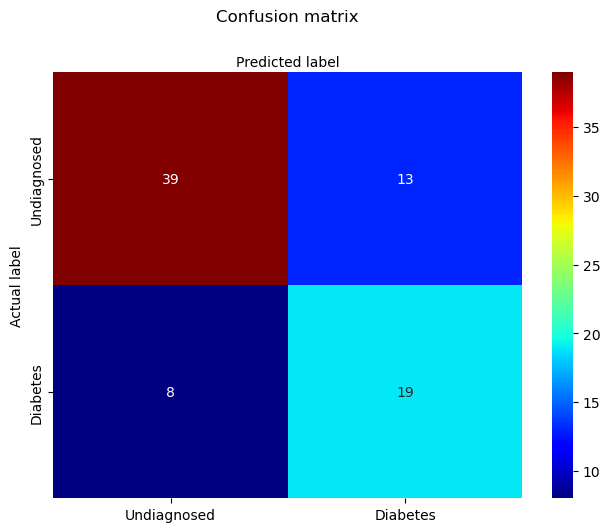

In [139]:
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="jet" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.xticks(tick_marks+0.5, class_names)
plt.yticks(tick_marks+0.5, class_names)
plt.show()

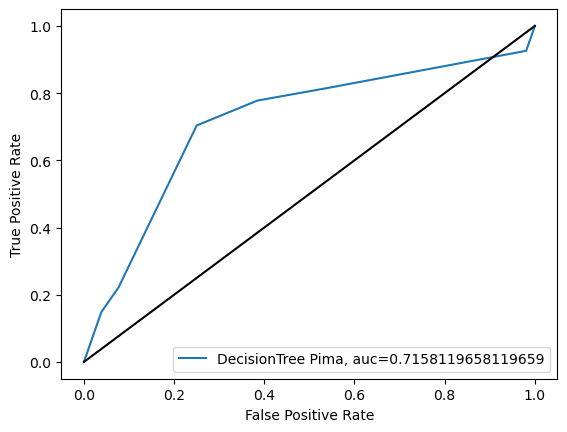

In [140]:
y_pprob = dt_pima.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test,  y_pprob[:,1])
auc = roc_auc_score(y_test, y_pprob[:,1])
plt.plot(fpr,tpr,label="DecisionTree Pima, auc="+str(auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot([0,1],[0,1],'k-')
plt.legend(loc=4)
plt.show()

### Hyperparameter

Setting the `max_depth` is choosing a **hyperparameter**.  This requires cross-validation and regularization to tune the hyper parameters  

This is what you ought to keep in mind about decision trees.

from the docs:
```
max_depth : int or None, optional (default=None)
The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
min_samples_split : int, float, optional (default=2)
```

- The deeper the tree, the more prone you are to overfitting.
- The smaller `min_samples_split`, the more the overfitting. One may use `min_samples_leaf` instead. More samples per leaf, the higher the bias.

### The Bootstrap

I am going to introduce an entirely different way of thinking about Statistics.  It was not introduced by Robert Tibshirani, but he took it and made it solid and wrote an influential book called **The Bootstrap**.


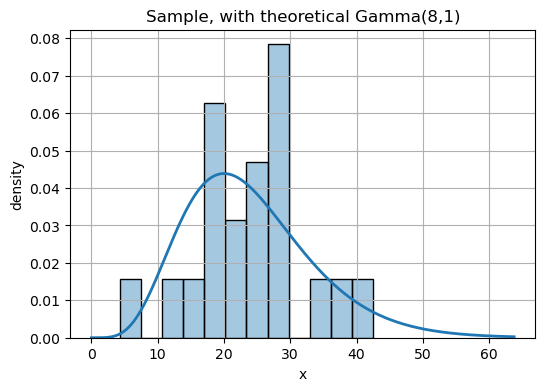

In [141]:
rng = np.random.default_rng(50)

shape, scale, n = 6, 4, 20
x  = rng.gamma(shape = shape, scale=scale, size=n)
xx = np.linspace(0, 1.5*max(x), 500)
ideal = gamma.pdf(xx, a=shape, scale=scale)

plt.figure(figsize=(6,4))
sns.histplot(x, stat="density", bins=12, alpha=0.4)
plt.plot(xx, ideal, linewidth=2)          # theoretical gamma(8,1)
plt.title("Sample, with theoretical Gamma(8,1)")
plt.xlabel("x")
plt.ylabel("density")
plt.grid(True)
plt.show()



In [142]:
x_mean = np.mean(x)
x_std  = np.std(x, ddof=1)
print("Sample mean: ", x_mean)
print("Sample std:  ", x_std)

Sample mean:  23.87071544044655
Sample std:   8.803932530370448


In [143]:
# bootstrap
B = 200
idx = rng.integers(0, n, (B, n))
boot_means = x[idx].mean(axis=1)

In [144]:
# 95% percentile CI
ci_low, ci_high = np.percentile(boot_means, [2.5, 97.5])
print(f"95% CI for mean = [{ci_low:.4f}, {ci_high:.4f}]")


95% CI for mean = [20.3397, 27.4342]


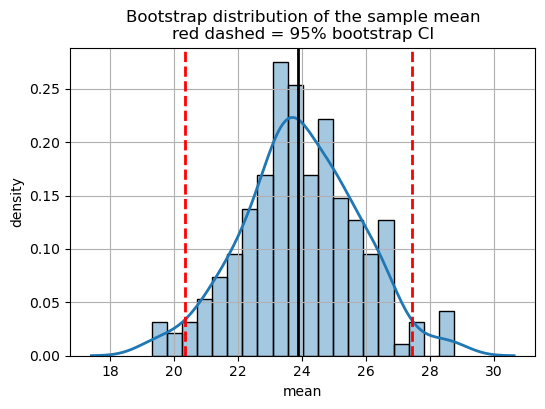

In [145]:
plt.figure(figsize=(6,4))
sns.histplot(boot_means, stat="density", bins=20, alpha=0.4)
sns.kdeplot(boot_means, linewidth=2)

# draw CI lines
plt.axvline(ci_low,  color="red", linestyle="--", linewidth=2)
plt.axvline(ci_high, color="red", linestyle="--", linewidth=2)

# also draw the sample mean
plt.axvline(x_mean, color="black", linestyle="-", linewidth=2)

plt.title("Bootstrap distribution of the sample mean\nred dashed = 95% bootstrap CI")
plt.xlabel("mean")
plt.ylabel("density")
plt.grid(True)
plt.show()

Consider the case of two samples drawn from different experimental conditions.  In a normal statistics class you would deploy a t-test to compare them. Here is how we can analyze the data with resampling methods. 

Mean 1 (k=8): 11.5876
Mean 2 (k=7): 8.6023
Observed difference (m1 - m2): 2.9853


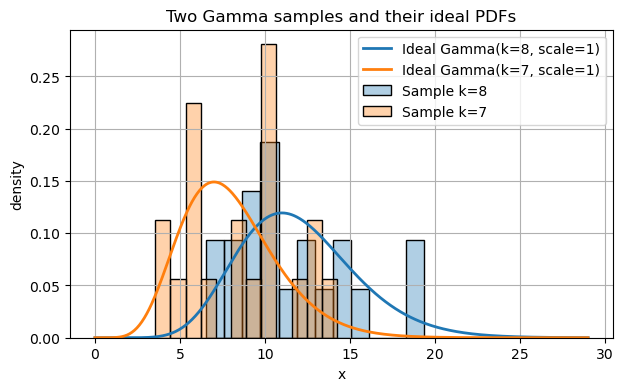

Bootstrap 95% CI for (mean1 - mean2): [0.9955, 5.1257]


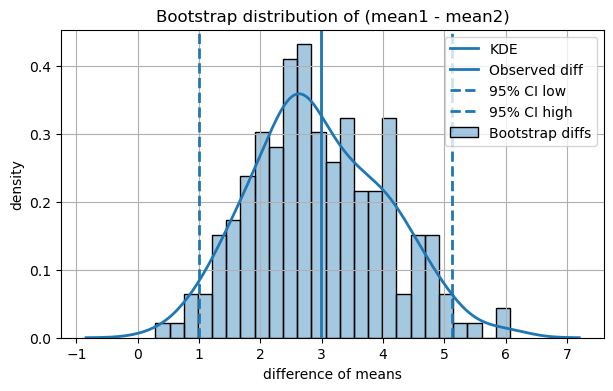

In [146]:

rng = np.random.default_rng(112)

# ---- Two Gamma distributions ----
k1, k2 = 12.0, 8.0     # shapes
scale = 1.0
n1 = n2 = 20

x1 = rng.gamma(shape=k1, scale=scale, size=n1)
x2 = rng.gamma(shape=k2, scale=scale, size=n2)

m1, m2 = x1.mean(), x2.mean()
diff_obs = m1 - m2

print(f"Mean 1 (k=8): {m1:.4f}")
print(f"Mean 2 (k=7): {m2:.4f}")
print(f"Observed difference (m1 - m2): {diff_obs:.4f}")

xx = np.linspace(0, max(x1.max(), x2.max()) * 1.5, 600)
pdf1 = gamma.pdf(xx, a=k1, scale=scale)
pdf2 = gamma.pdf(xx, a=k2, scale=scale)

plt.figure(figsize=(7,4))
sns.histplot(x1, stat="density", bins=12, alpha=0.35, label="Sample k=8")
sns.histplot(x2, stat="density", bins=12, alpha=0.35, label="Sample k=7")
plt.plot(xx, pdf1, linewidth=2, label="Ideal Gamma(k=8, scale=1)")
plt.plot(xx, pdf2, linewidth=2, label="Ideal Gamma(k=7, scale=1)")
plt.title("Two Gamma samples and their ideal PDFs")
plt.xlabel("x"); plt.ylabel("density"); plt.grid(True); plt.legend()
plt.show()


B = 200  # number of bootstrap replicates
idx1 = rng.integers(0, n1, size=(B, n1))
idx2 = rng.integers(0, n2, size=(B, n2))
boot_means1 = x1[idx1].mean(axis=1)
boot_means2 = x2[idx2].mean(axis=1)
boot_diff = boot_means1 - boot_means2

# 95% percentile CI for the difference
ci_low, ci_high = np.percentile(boot_diff, [2.5, 97.5])
print(f"Bootstrap 95% CI for (mean1 - mean2): [{ci_low:.4f}, {ci_high:.4f}]")

# ---- Plot 2: Bootstrap distribution of the difference ----
plt.figure(figsize=(7,4))
sns.histplot(boot_diff, stat="density", bins=25, alpha=0.4, label="Bootstrap diffs")
sns.kdeplot(boot_diff, linewidth=2, label="KDE")
plt.axvline(diff_obs, linestyle="-", linewidth=2, label="Observed diff")
plt.axvline(ci_low,  linestyle="--", linewidth=2, label="95% CI low")
plt.axvline(ci_high, linestyle="--", linewidth=2, label="95% CI high")
plt.title("Bootstrap distribution of (mean1 - mean2)")
plt.xlabel("difference of means"); plt.ylabel("density")
plt.grid(True); plt.legend()
plt.show()


### Bagging (Bootstrap Aggregation)

One way to adjust for the high variance of the output of an experiment is to perform the experiment multiple times and then average the results.

The same idea can be applied to high variance models to protect from overfitting:

1. (Bootstrap) we generate multiple samples of training data, via bootstrapping. We train a full decision tree on each sample of data.
2. (Aggregate)for a given input, we output the averaged outputs of all the models for that input. For classification, we return the class that is outputted by the plurality of the models. For regression we return the average of the outputs for each tree.

This method is called Bagging (Breiman, 1996), short for, of course, Bootstrap Aggregating.

This approach is a form of regularization, and is actually the basis of modern approaches to gradient descent called Stochastic Gradient Descent (SDG).  In SDG on each step of the search to minimize a loss function a bootstrap sample of the data is used instead of all of the data.  

It is possible to use a method called `BaggingClassifier` in sklearn to do this, but we are going to skip this and go to an even better idea. 

### Random Forest Classifier
There are two main limitations of decision trees: 
* Decision trees are greedy optimization methods. 
* Manual inspection of a whole set of models with different numbers of features is time consuming. This might be ok when we work with a small number of features. 
There are a number of approaches that have been developed to objectively select a decision tree.  I give an example of a widely used one called a Random Forest. 
The idea behind a random forest is to fit a large number of models, with some randomness

### Random Forests
Random Forest creates ensembles of independent decision trees:

1. Train each tree on a separate random sample of the full training set
2. For each tree, at each split, we randomly select a subset of $J^{\prime}$ predictors from the full set of predictors.
3. From amongst the $J^{\prime}$ predictors, we select the optimal predictor and the optimal corresponding threshold for the split.
4. The results of all the trees are then averaged together ("voting") to make the prediction.

There are two bootstraps here - one to sample the data, and one to sample the predictors. 

In [147]:

n_trees = 500
rf_pima = RandomForestClassifier(n_estimators=n_trees, random_state = 42)
rf_pima.fit(X_train,y_train)

RandomForestClassifier(n_estimators=500, random_state=42)

In [148]:
y_pred = rf_pima.predict(X_test)
print('accuracy score: ', rf_pima.score(X_test,y_test))

accuracy score:  0.759493670886076


In [149]:
cnf_matrix = confusion_matrix(y_test, y_pred)
print(cnf_matrix)

[[45  7]
 [12 15]]


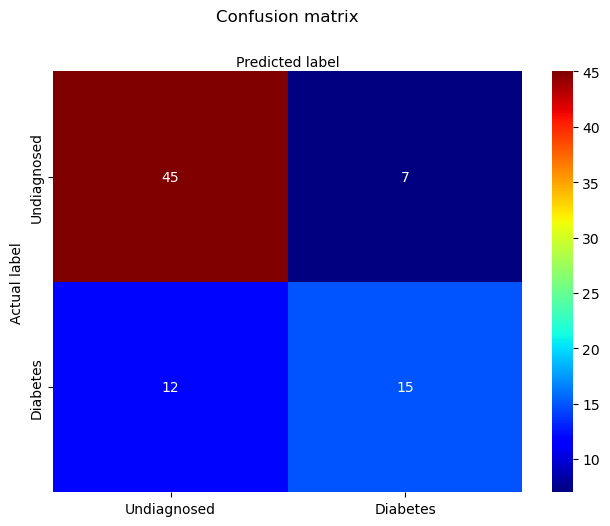

In [150]:
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="jet" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.xticks(tick_marks+0.5, class_names)
plt.yticks(tick_marks+0.5, class_names)
plt.show()

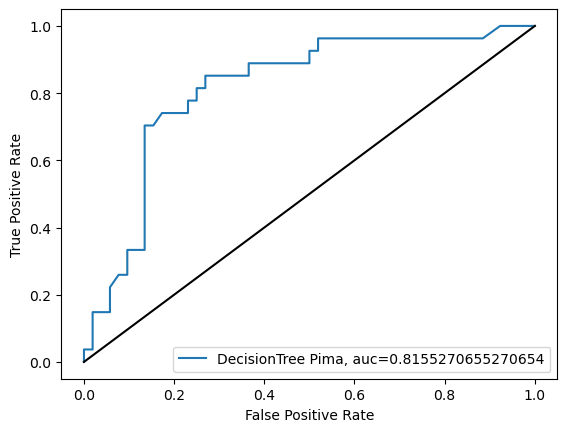

In [151]:
y_pprob = rf_pima.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test,  y_pprob[:,1])
auc = roc_auc_score(y_test, y_pprob[:,1])
plt.plot(fpr,tpr,label="DecisionTree Pima, auc="+str(auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot([0,1],[0,1],'k-')
plt.legend(loc=4)
plt.show()

* You should be able to quickly convince yourself that making a model with a lot of depth does not buy you anything. 
* Its more robust to keep the depth low and aggregate over many shallow models. 
* Wisdom of crowd type of model. 
  

### Classical  Approach to Interpretation. 
* For interpretation, the problem is I cant draw a tree now, because I used 500 trees to make this model.
* What I can do, is to investigate the importance of feature to the aggregate models  

### Permutation Importance

1. Closely related to the bootstrap is the permutation test.  
2. We usually use permutation tests when working with paired data. 
3. The idea of the permutation test is to keep all the samples of each but shuffle them. 
4. In this way, the distribution of each variable is unchanged.  
5. But the **association** between variables has been removed. 
5. Measure the loss of performance relative to the original test data.

Simple example: 
- You measure a correlation between x and y.  
- Then you shuffle the values of y, and measure the correlation. 
- This tell you how much correlation there would be by chance.  
- To make a better estimate, maybe do this 100 times and average to tell you the chance level of correlation.

For any sklearn model, we can use `permutation_importance`

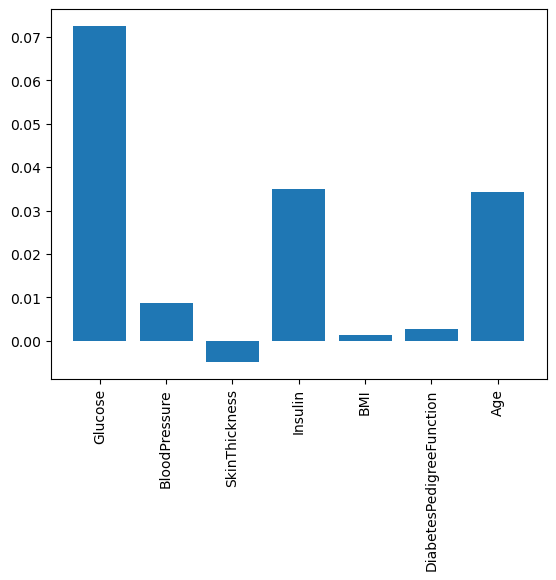

In [152]:

result = permutation_importance(rf_pima,X_test,y_test,n_repeats = 100)
plt.bar(feature_names,result['importances_mean'])
plt.xticks(feature_names,rotation=90)
plt.show()

### Partial Dependence

Given a set of features $x_s$ and its complement $x_c$, 

$$ pd(x_s) = \int f(x_s,x_c)p(x_c)p(x_c)dx_c $$

Here $f$ is (for example) the prediction probabilty of a given sample. 
Typically we can average this over the training samples.  

In [153]:


predictions = partial_dependence(rf_pima, X_train,features = [0],kind = 'average' )

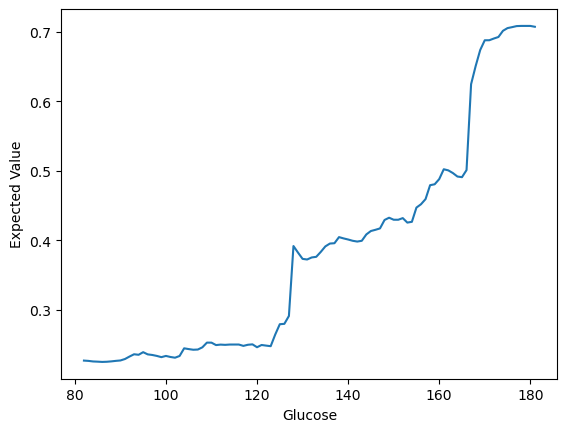

In [154]:
plt.plot(predictions['grid_values'][0],predictions['average'][0])
plt.xlabel('Glucose')
plt.ylabel('Expected Value')
plt.show()

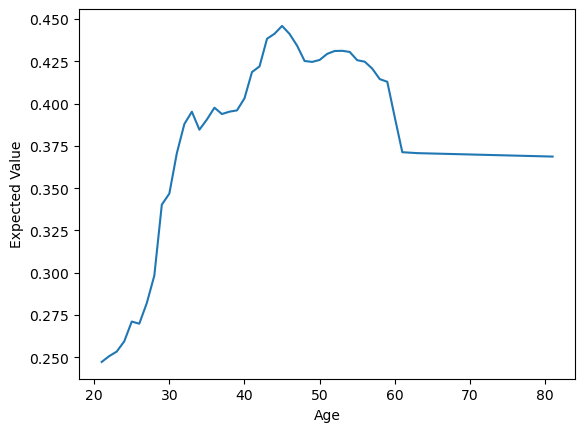

In [155]:
predictions = partial_dependence(rf_pima, X_train,features = [6],kind = 'average' )
plt.plot(predictions['grid_values'][0],predictions['average'][0])
plt.xlabel('Age')
plt.ylabel('Expected Value')
plt.show()

## The limitations of random forest

#### When can Random Forest overfit? 
- Increasing the number of trees in RF generally doesn't increase the risk of overfitting, BUT if the number of trees in the ensemble is too large then the trees in the ensemble may become correlated, and therefore increase the variance.

#### When can Random Forest fail? 

- **When we have a lot of predictors that are completely independent of the response and a few overwhelmingly influential predictor**.


Boosting Classifiers - ADABoost and XGBoost
            
            pip install xgboost

XGboost is not part of sklearn and has to be installed separately.

<img src="boosting_2.png?" alt="tree_adj" width="70%"/>